In [835]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
# os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation
from numba import njit
from scipy.sparse import csr_matrix
import re
import matplotlib.pyplot as plt

# from pypfopt.efficient_frontier import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pypfopt import base_optimizer

import vectorbt as vbt
from vectorbt.generic.nb import nanmean_nb
from vectorbt.portfolio.nb import create_order_nb, auto_call_seq_ctx_nb
from vectorbt.portfolio.enums import SizeType, Direction

### Read this again

I need to take full advantage of the indexing before i start bulding stuff outside of it. Reread this to understand how he's doing a dict of multiple cols or whatev. Its multi asset. https://polakowo.medium.com/stop-loss-trailing-stop-or-take-profit-2-million-backtests-shed-light-dde23bda40be



In [1002]:
# df = pd.read_csv('/Users/xbno/Downloads/pred_bt_gt_1_lo.csv.gz')
# df = pd.read_csv('/Users/xbno/Downloads/leftjoin.csv')
# df = pd.read_csv('/Users/xbno/Downloads/leftjoino.csv')
df = pd.read_csv('/Users/xbno/Downloads/20210101_pred_bt_full_version_64.csv')
df['oc_hx_date'] = pd.to_datetime(df['oc_hx_date'])
df['s_hx_date'] = pd.to_datetime(df['s_hx_date'])
df.set_index(["oc_hx_date", "oc_hx_contract_symbol"], inplace=True)
df = df.sort_index()
# df.head().T

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning:

Columns (0,2,3) have mixed types.Specify dtype option on import or set low_memory=False.



### Create entry/exit for vectorbt - fails on local due to int32 overflow/mem

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [844]:
# df[~df['contract_symbol'].isnull()].head().T
# df.memory_usage(deep=True)

### Create entry/exit for vectorbt - Working with reduced symbols

Same shape as option_contract price history. Need to shift these 1 position downward so to simulate buying the next day.

These are the trades to copy:

In [1003]:
rand_symbols = np.random.choice(df[~df['contract_symbol'].isnull()]['s_hx_symbol'].unique(),size=500,replace=False)
# rand_symbols = ["AMRS","CCL"]
rand_contract_symbols = df[(~df['contract_symbol'].isnull())&(df['s_hx_symbol'].isin(rand_symbols))]['contract_symbol']

In [1004]:
# df = df[(df['s_hx_symbol'].isin(['BB','AMC','FEYE']))&(df['s_hx_date'] >= '2020-12-01')]
# df = df[(df['contract_symbol'].isin(rand_contract_symbols))&(df['s_hx_date'] >= '2020-12-01')]
df = df.loc[idx[:,rand_contract_symbols],:]
df.shape

(271521, 26)

In [847]:
# rand = vbt.RAND.run(n=[i for i in range(df.shape[1])], input_shape=(df.shape[0],), seed=42)
# entries = rand.entries
# exits = rand.exits

# entries.iloc[:,:] = False
# entries.iloc[0,:] = True
# exits.iloc[:,:] = False

I can optimize this by reducing the entry_df size down to only contract_symbols that have trades, since I'm only keeping thresholded trades.. would need to reduce df at the same time.

In [1126]:
def uniform_pred_thresh_entry(df,thresh=0,reduce=False):
    idx = pd.IndexSlice
    if reduce == False:
        entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].last().unstack() > thresh
        entry_df = entry_df.shift(1)
        entry_df = entry_df.fillna(False)
        print(f"df:{df.shape}, entry_df:{entry_df.shape}")
        return df, entry_df
    else:
        entry_df = df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].last().unstack() > thresh
        entry_df = entry_df.shift(1)
        entry_df = entry_df.fillna(False)
        entry_df = entry_df.loc[:,entry_df.astype(int).sum(axis=0)!=0]
        df = df.loc[idx[:,entry_df.columns],:]
        print(f"df:{df.shape}, entry_df:{entry_df.shape}")
        return df, entry_df
    
df, entry_df = uniform_pred_thresh_entry(df,thresh=2.0,reduce=True)

df:(27123, 26), entry_df:(111, 604)


In [1128]:
def parse_contract_symbol(cs):
    "expects contract symbol like 'WKHS200717C00002500' and returns formatted versions of gleenable info to add to df"
    if isinstance(cs,str):
        cs = cs
#     elif isinstance(cs,pd.DataFrame):
#         cs = row['contract_symbol']
#     elif isinstance(cs,pd.Series):
#         cs = row['contract_symbol']
    else:
        cs = cs['contract_symbol']
    price_part = cs[-8:]
    option_type = cs[-9]
    date_part = cs[-15:-9]
    root_part = cs[:-15]
    symbol_part = re.match("[A-Z]*", root_part).group()

    price_part = int(price_part) / 1000
    type_part = {"C": "CALL", "P": "PUT"}[option_type]
    date_part = datetime.strptime(date_part, "%y%m%d").strftime("%Y-%m-%d")

    return {
        "option_expiration": date_part,
        "symbol": symbol_part,
        "root": root_part,
        "strike": price_part,
        "type": type_part,
    }

In [1129]:
def expiration_exit(entry_df):
    exp_exit_df = entry_df.copy()
    exp_exit_df.iloc[:,:] = False

    tmp_df = entry_df.sum()[entry_df.sum()!=0].reset_index()
    tmp_df = tmp_df.rename(columns={'oc_hx_contract_symbol':'contract_symbol'})
    tmp_df[['option_expiration','symbol','root','strike','type']] = tmp_df.apply(parse_contract_symbol,axis=1,result_type="expand")
    exits = tmp_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

    for exit in exits:
        exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True
    return exp_exit_df

exp_exit_df = expiration_exit(entry_df)

In [ ]:
def pct_inc_exit(entry_df,thresh=1):
    

**DO THIS** 

Work on setting up the exit stat where you exit everything when the value is gt X pct. should probably look into documentation since there were rolling window type things like this. i think he structured his frames completely differently, including all relevant info within the df_tmp itself to dynamically change on the fly instead of hardcoding the exit prior to running

In [1238]:
r,c = np.where(pct_inc_df>2)
pd.DataFrame(np.column_stack((pct_inc_df.index[r],pct_inc_df.columns[c],pct_inc_df.values[r,c])))

,0,1,2
0,1612396800000000000,"(CALL, FITB, 2021-02-19, FITB210219C00032000)",2.11111
1,1612742400000000000,"(CALL, CLNE, 2021-02-19, CLNE210219C00015000)",7.11111
2,1612742400000000000,"(CALL, CLNE, 2021-03-19, CLNE210319C00020000)",4.43636
3,1612742400000000000,"(CALL, FITB, 2021-02-19, FITB210219C00032000)",2.22222
4,1612742400000000000,"(CALL, MVIS, 2021-02-19, MVIS210219C00016000)",5.78125
...,...,...,...
712,1623369600000000000,"(CALL, NIO, 2021-06-11, NIO210611C00042000)",2.84615
713,1623369600000000000,"(CALL, NIO, 2021-06-11, NIO210611C00042500)",2.81416
714,1623369600000000000,"(CALL, NIO, 2021-06-11, NIO210611C00043000)",2.78351
715,1623369600000000000,"(CALL, NIO, 2021-06-11, NIO210611C00044000)",2.31081


In [ ]:

arr = df.values
index_names = df.index
col_names = df.columns

#  Get indices where such threshold is crossed; avoid diagonal elems
R,C = np.where(np.triu(arr,1)>0.6)

# Arrange those in columns and put out as a dataframe
out_arr = np.column_stack((index_names[R],col_names[C],arr[R,C]))
df_out = pd.DataFrame(out_arr,columns=[['row_name','col_name','value']])

In [1227]:
thresh = 1

In [1206]:
entry_price_df = (entry_df*df_tmp).replace(0,np.nan).ffill()

In [1230]:
pct_inc_df = df_tmp / entry_price_df

In [1232]:
pct_inc_df[pct_inc_df > thresh]#.stack()

option_type                          CALL                      \
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                      

In [1226]:
(df_tmp / entry_price_df).ge(1)

option_type                          CALL                      \
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

option_type                                                    \
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                          False               False   
2021-06-10                          False               False   
2021-06-11                          False               False   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                          False               False   
2021-01-05                          False               False   
2021-01-06                          False               False   
2021-01-07                          False               False   
2021-01-08                          False               False   
...                                   ...                 ...   
2021-06-07                          False               False   
2021-06-08                          False               False   
2021-06-09                      

In [1213]:
(df_tmp / entry_price_df).loc[:,idx[:,:,:,'YCBD210219C00007500']].dropna()

option_type,CALL
symbol,YCBD
option_expiration,2021-02-19
oc_hx_contract_symbol,YCBD210219C00007500
Date,
2021-02-05,1.000000
2021-02-08,1.333333
2021-02-09,2.000000
2021-02-10,2.333333
2021-02-11,0.666667
2021-02-12,0.333333


In [ ]:
df.reset_index().groupby(['oc_hx_date','oc_hx_contract_symbol'])['y_pred'].last().unstack() > thresh

### Setup wide data for vectorbt

One column per option_contract series

In [1134]:
# exp_exit_df.loc[:"2021-02-19"]

In [1135]:
df_tmp = df[[c for c in df.columns if 'oc_hx' in c]]
df_tmp = df_tmp.reset_index().set_index('oc_hx_date') #.set_index('oc_hx_symbol')
df_tmp = df_tmp.sort_index()
df_tmp = df_tmp.groupby(['oc_hx_date','oc_hx_contract_symbol'])['oc_hx_close'].max().unstack().dropna(how='all')

for exit in exits:
    df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']] = df_tmp.loc[:exit['option_expiration'],exit['contract_symbol']].ffill()

df_tmp.index.name = 'Date'

df_tmp_save = df_tmp.copy()

# old single index
# df_tmp = df_tmp.vbt.stack_index(pd.Index([re.match('[A-Z]*',c)[0] for c in df_tmp.columns], name='symbol'))
# df_tmp.vbt.stack_index(pd.Index([format_date(re.search('[0-9]+',c)[0]) for c in df_tmp.columns], name='option_expiration'))

# new multi index
multi_ind = list(zip(
    [parse_contract_symbol(c)['type'] for c in df_tmp.columns],
    [parse_contract_symbol(c)['symbol'] for c in df_tmp.columns],
    [parse_contract_symbol(c)['option_expiration'] for c in df_tmp.columns]
))
df_tmp = df_tmp.vbt.stack_index(pd.MultiIndex.from_tuples(multi_ind, names=["option_type", "symbol", "option_expiration"]))
df_tmp

option_type                          CALL                      \
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                           3.50                 NaN   
2021-01-05                           3.70                 NaN   
2021-01-06                           2.65                 NaN   
2021-01-07                           3.59                 5.7   
2021-01-08                           3.90                 6.1   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            NaN                 NaN   
2021-01-05                            NaN                 NaN   
2021-01-06                            NaN                 NaN   
2021-01-07                            NaN                 NaN   
2021-01-08                            NaN                 NaN   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                            NaN                 NaN   
2021-06-10                            NaN                 NaN   
2021-06-11                            NaN                 NaN   

option_type                                                    \
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                           8.77                6.65   
2021-01-05                           9.30                7.07   
2021-01-06                           7.20                5.45   
2021-01-07                           9.15                7.00   
2021-01-08                           9.75                7.45   
...                                   ...                 ...   
2021-06-07                            NaN                 NaN   
2021-06-08                            NaN                 NaN   
2021-06-09                      

In [1039]:
exp_exit_df = entry_df.copy()
exp_exit_df.iloc[:,:] = False

entry_exit_df = df.dropna(subset=['contract_symbol'])
entry_exit_df[['option_expiration','symbol','root','strike','type']] = entry_exit_df.apply(parse_contract_symbol,axis=1,result_type="expand")
entry_exit_df = entry_exit_df[['contract_symbol','option_expiration','purch_date']].drop_duplicates()
exits = entry_exit_df[['contract_symbol','option_expiration']].drop_duplicates().to_dict('records')

for exit in exits:
    exp_exit_df.loc[exit['option_expiration'],exit['contract_symbol']] = True

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/pandas/core/indexes/multi.py:1908: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



TypeError: only integer scalar arrays can be converted to a scalar index

### Create multiple random exits

Compare random exits to the exiting at expiration

In [1136]:
exit_df = exp_exit_df.copy()
exit_df.columns = df_tmp.columns
entry_df.columns = df_tmp.columns

rand_exit_types = [f'rand_{i}' for i in range(10)]
rand_exit_dfs = {}
for rand_exit_type in rand_exit_types:
    rand_exit_df = vbt.IRPROBEX.run(
        entry_df, 
        df_tmp,
    ).exits
    rand_exit_df.columns = entry_df.columns
    rand_exit_dfs[rand_exit_type] = rand_exit_df

# for r in rand_exit_types:
#     print(f"rand_exit_dfs['{r}'],")
    
exit_types = rand_exit_types + ['expiration']
all_exit_df = pd.DataFrame.vbt.concat(
    rand_exit_dfs['rand_0'],
    rand_exit_dfs['rand_1'],
    rand_exit_dfs['rand_2'],
    rand_exit_dfs['rand_3'],
    rand_exit_dfs['rand_4'],
    rand_exit_dfs['rand_5'],
    rand_exit_dfs['rand_6'],
    rand_exit_dfs['rand_7'],
    rand_exit_dfs['rand_8'],
    rand_exit_dfs['rand_9'],
    exp_exit_df,
    keys=pd.Index(exit_types, name='exit_type')
)

In [1137]:
assert df_tmp.shape == entry_df.shape == exp_exit_df.shape
# assert df_tmp.columns == entry_df.columns == exp_exit_df.columns

### Show trades

This is excellent! Potentially figure out how to add this to a dashboard with a selector. 

Inspiration also here: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/PortfolioOptimization.ipynb Looks like there could be a much better way of indexing these.


### Dashboard inspiration
Probably will need to create a dashboard using dash components: https://github.com/facultyai/dash-bootstrap-components like this: https://github.com/polakowo/vectorbt/tree/master/apps/candlestick-patterns.

Example here: https://candlestick-patterns.herokuapp.com/

In [1138]:
contract_symbol = df_tmp.columns[-1]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

contract_symbol = df_tmp.columns[-21]
fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

fig.show()

In [855]:
# symbol = 'FEYE'
# option_expiration = '2021-01-08'
# option_type = 'Call'
# contract_symbols = [
#     c for c in df_tmp.columns 
#         if symbol in c 
#         and option_expiration in c
#         and option_type in c
# ]
# print(f"{len(contract_symbols)} Traces")
# contract_symbol = contract_symbols[0]
# fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'))
# fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
# fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

# for contract_symbol in contract_symbols[1:50]:
#     fig = df_tmp[contract_symbol].dropna().vbt.plot(trace_kwargs=dict(name=f'{contract_symbol}'), fig=fig)
#     fig = entry_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_entry_markers(df_tmp[contract_symbol].dropna(), fig=fig)
#     fig = exit_df.loc[df_tmp[contract_symbol].dropna().index,contract_symbol].vbt.signals.plot_as_exit_markers(df_tmp[contract_symbol].dropna(), fig=fig)

# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=800,)
# fig.show()

### Working with pd.MultiIndex

Slicing

In [1058]:
# find example to inspect
# entry_df.sum()[entry_df.sum()!=0]
# a = entry_df.loc(axis=1)[:,:,:,['AMC210305C00007000']]
# a[a].dropna()

idx = pd.IndexSlice
entry_df.loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: bool)

### Create vectorbt portfolio.from_orders()

Join entry_df and exit_df that had been created for the signals version to create +/- values for orders

In [214]:
# entry_sz = entry_df.astype(int) * 10 * 100
# exit_sz = exit_df.astype(int) * entry_sz.sum()
# entry_exit_sz = entry_sz - exit_sz

# # converts old pandas entry_exit_sz sparse version (didn't work as sparse, so unnecessary)
# row = []
# col = []
# data = []
# for i,r in enumerate(entry_exit_sz.index):
#     for j,c in enumerate(entry_exit_sz.columns):
#         if entry_exit_sz.loc[r,c] == 0:
#             continue
#         else:
#             row.append(i)
#             col.append(j)
#             data.append(entry_exit_sz.loc[r,c])

# col_size = j+1
# row_size = i+1

# # entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size)))  # doesnt' work
# entry_exit_sz = csr_matrix((data, (row, col)), shape=((row_size,col_size))).toarray()

In [27]:
# portfolio = vbt.Portfolio.from_orders(
# #     df_tmp,
#     price,
#     size=entry_exit_sz, 
#     min_size=0,
#     max_size=10000, 
# #     group_by=True,
# #     group_by=symbol_groups, 
#     log=True, 
#     fees=0.001, 
#     slippage=0.001,
# #     init_cash='auto',
#     init_cash='autoalign',
# #     cash_sharing=True, 
#     direction='longonly',
#     freq='1D',
# )

# portfolio.total_return()

# Brainstorming

### Entry logic
- Only buy at 1/2 price of original trade
- Buy X at orig price, Y at .75 * orig price, Z at .5 * orig price. Good til expired
- 

### Exit logic
- Set X% stop loss for Z% of shares, after Y% increase
    - Sell 1/2 of shares at 20% max drawdown, after hitting 50% increase
- Sell Z% of shares after Y% increase 
    - Sell all shares after 100% increase
    - Sell 1/2 shares after 100% increase and other 1/2 after 200% increase

### Create vectorbt portfolio.from_orders()

Create rand exiting to compare to expiration exiting. Inspired from: https://nbviewer.jupyter.org/github/polakowo/vectorbt/blob/master/examples/StopSignals.ipynb

The idea is that if I can create exit signals based on actual functions than I can actually beomce confident in which is the best/safest method overall.

- Entry signal same for all
- Exit signal random each time

In [1140]:
def uniform_cash_order_sizing(df_tmp,entry_size_df,max_cash_per_trade=150,return_share_size=True):
    entry_contract_size_df = (max_cash_per_trade // (df_tmp * 100 * entry_size_df)).replace([np.inf, -np.inf], np.nan).fillna(0)
    if return_share_size:
        return entry_contract_size_df * 100
    else:
        return entry_contract_size_df

def uniform_quantity_order_sizing(df_tmp,entry_size_df,max_quantity_per_trade=10):
    return (max_quantity_per_trade * entry_size_df).replace([np.inf, -np.inf], np.nan).fillna(0)

uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),100).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]
uniform_quantity_order_sizing(df_tmp,entry_df.copy().astype(int),500).loc[idx['2021-02-17'],idx[:,:,:,['AMC210305C00007000']]]

Series([], Name: 2021-02-17 00:00:00, dtype: int64)

In [1141]:
import gc

max_cash_per_trade = 500
total_returns = []
for exit_type in exit_types:
    entry_size_df = uniform_cash_order_sizing(df_tmp,entry_df.copy().astype(int),max_cash_per_trade)
    chunk_exit_df = all_exit_df.loc[:,all_exit_df.columns.get_level_values('exit_type') == exit_type]
    entry_size_df.columns = chunk_exit_df.columns
    exit_size_df = chunk_exit_df.astype(int) * entry_size_df.sum()
    entry_exit_size_df = entry_size_df - exit_size_df
    
    portfolio = vbt.Portfolio.from_orders(
        df_tmp,  # grouped by exit_type, symbol, contract_symbol
        size=entry_exit_size_df, 
        min_size=0,
        max_size=500000, 
        log=True, 
        fees=0.001, 
        slippage=0.00,
        init_cash='autoalign', #50000,
        direction='longonly',
        freq='1D',
    )
    total_returns.append(portfolio.total_return())

    if exit_type == 'expiration':
        pass
    else:
        del portfolio
    gc.collect()
    
total_return = pd.concat(total_returns)

print(total_return.shape)

(6644,)


In [1143]:
total_return_by_type = total_return.unstack(level='exit_type')[exit_types]

print(pd.DataFrame({
    'Mean': total_return_by_type.mean(),
    'Median': total_return_by_type.median(),
    'Std': total_return_by_type.std(),
}))

total_return_by_type.vbt.boxplot(
    yaxis_title='Total return',
    yaxis_tickformat='%'
).show()


                Mean    Median       Std
exit_type                               
rand_0     -0.007809 -0.009940  0.118894
rand_1     -0.005056 -0.007996  0.100977
rand_2     -0.004714 -0.006274  0.086706
rand_3     -0.007010 -0.020099  0.244250
rand_4     -0.009973 -0.017559  0.180060
rand_5     -0.009978 -0.013131  0.137002
rand_6     -0.006613 -0.012744  0.127427
rand_7     -0.011317 -0.012319  0.129408
rand_8     -0.012439 -0.017220  0.172638
rand_9     -0.006448 -0.011859  0.144338
expiration -0.057731 -0.066875  0.175282


### Portfolio: Trades, Orders. Not sure what to do with these yet

All columns show the current snapshot prior to fulfilling the log record action. For example, cash now = 50000 on the first trade. shares now = 0 on the first trade. Also, every cell is traversed during the calculations and `non_order` logs are `-1`

Columns of Note:
- `cash_now`: the total cash in the portfolio
- `value_now`: the total portfolio value (cash + positions held)

In [1144]:
order_df = portfolio.logs.records
order_df[order_df['order_id'] != -1].head(2)

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
26,26,26,0,0,inf,0.0,0.78,inf,600.0,0,...,True,inf,600.0,600.0,0.78,0.468,0,0,-1,0
32,32,32,0,0,inf,600.0,0.01,inf,-600.0,0,...,True,inf,0.0,600.0,0.01,0.006,1,0,-1,1


In [1145]:
portfolio.orders.records.head()

,id,idx,col,size,price,fees,side
0,0,26,0,600.0,0.78,0.468,0
1,1,32,0,600.0,0.01,0.006,1
2,2,21,2,100.0,4.20,0.420,0
3,3,42,2,100.0,0.01,0.001,1
4,4,21,3,100.0,2.75,0.275,0


In [1146]:
trades_df = portfolio.trades.records
trades_df['pnl'].sum()

# same as 
# portfolio.regroup(group_by=None).total_profit().sum()

-238011.061

### Ratios, Profits, etc

When running this for all symbols, I can do ablation on the top X and figure out the what the gains would still be. If I'm clever about it, I can include the symbol price history as well, and ablate based on the gains of it? That way I could remove abnormally high winners, like AMC, BB recently.

In [1147]:
# can group by in order like this, but not alone
portfolio.total_return(group_by=['symbol'])
portfolio.total_return(group_by=['symbol','option_expiration'])
portfolio.total_return(group_by=['symbol','option_expiration','option_type'])
portfolio.total_return(group_by='exit_type')
# portfolio.total_return(group_by='option_type').sort_values(ascending=False)  # ValueError: Groups must be coherent and sorted

portfolio.total_return(group_by=['symbol'])

symbol
AAPL     -0.079398
ADNT      0.004170
AER      -0.003011
AMRS     -0.012646
AMZN      0.000000
            ...   
WYNN     -0.009773
XL       -0.010148
XOM      -0.014494
YCBD     -0.002909
ZM       -0.002709
Length: 103, dtype: float64

In [682]:
# drop_half = portfolio.total_return().index.shape[0] // 2
# portfolio.total_return(group_by=False).sort_values(ascending=False).index[drop_half:]

# option_expiration = '2021-01-08'
# select_index = [i for i,c in enumerate(portfolio.total_return().index) if option_expiration in c]
# portfolio.total_return(group_by=False).index[select_index]

# unablated_contract_symbols = portfolio.total_return(group_by=False).sort_values(ascending=False).index[3:]
# unablated_contract_symbols

# portfolio.regroup(group_by='option_expiration').total_return(group_by='option_expiration')

In [1148]:
portfolio.stats(group_by='symbol')

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:232: RuntimeWarning:

invalid value encountered in true_divide



Start                            2021-01-04 00:00:00
End                              2021-06-11 00:00:00
Duration                           111 days 00:00:00
Init. Cash                                    136335
Total Profit                                -2310.79
Total Return [%]                            -1.69493
Benchmark Return [%]                         10.5696
Position Coverage [%]                        21.1635
Max. Drawdown [%]                            3.54824
Avg. Drawdown [%]                            1.99136
Max. Drawdown Duration              59 days 13:55:12
Avg. Drawdown Duration       32 days 23:18:07.200000
Num. Trades                                  5.46602
Win Rate [%]                                 10.8107
Best Trade [%]                               47.8419
Worst Trade [%]                              -35.493
Avg. Trade [%]                              -14.7573
Max. Trade Duration                 29 days 10:48:00
Avg. Trade Duration       24 days 16:37:33.445

In [1149]:
(portfolio.sortino_ratio(group_by='symbol'),
portfolio.sharpe_ratio(group_by='symbol'),
portfolio.omega_ratio(risk_free=.02,required_return=.05,group_by='symbol'))

(symbol
 AAPL   -0.926321
 ADNT    1.244549
 AER    -1.445878
 AMRS   -2.310335
 AMZN         inf
           ...   
 WYNN   -0.935685
 XL     -2.439868
 XOM    -0.980790
 YCBD   -0.846393
 ZM     -2.397576
 Length: 103, dtype: float64,
 symbol
 AAPL   -0.557705
 ADNT    0.624580
 AER    -1.013100
 AMRS   -1.807329
 AMZN         inf
           ...   
 WYNN   -0.631354
 XL     -1.988893
 XOM    -0.689568
 YCBD   -0.758842
 ZM     -1.714994
 Length: 103, dtype: float64,
 symbol
 AAPL    0.093568
 ADNT    0.000000
 AER     0.000000
 AMRS    0.000000
 AMZN    0.000000
           ...   
 WYNN    0.000000
 XL      0.000000
 XOM     0.000000
 YCBD    0.000000
 ZM      0.000000
 Length: 103, dtype: float64)

In [1196]:
# portfolio.total_return()
# portfolio.value()
# # one_group = pd.Index(['one' for c in df_tmp.columns], name='group')
# # portfolio.net_exposure(group_by=symbol_groups)#.sum(axis=1).plot() #drawdown()
# portfolio.net_exposure()#.sum(axis=1).plot() #drawdown()

In [1150]:
portfolio.total_profit(group_by='symbol')

symbol
AAPL   -10824.741
ADNT      568.470
AER      -410.550
AMRS    -1724.116
AMZN        0.000
          ...    
WYNN    -1332.377
XL      -1383.586
XOM     -1976.091
YCBD     -396.594
ZM       -369.371
Length: 103, dtype: float64

# Digging into best/worst Trades

Need to figure out how to gather all the entries for a single contract into a single graph for the profit and loss. Also need to restriction of only allowing X amount of money into a given contract, if it already has so many already being held

In [1155]:
from vectorbt.portfolio.enums import OrderStatus
order_status_df = portfolio.logs.map_field('res_status', value_map=OrderStatus).value_counts()
contracts = order_status_df.loc[:,order_status_df.loc['Ignored'] != 111].columns.tolist()

# unkonwn whats good about this
# portfolio.total_profit(group_by=None).reset_index().groupby(['symbol','option_expiration'])[0].sum()
# a = portfolio.total_profit(group_by=None).reset_index()
# a[a['symbol'] == 'FEYE'].groupby(['symbol','option_expiration'])[0].sum().plot()

portfolio[contracts].total_profit().reset_index().sort_values(by=[0],ascending=False)
# portfolio[contracts].total_profit().reset_index().sort_values(by=[0],ascending=False)[0].hist(bins=50)

,exit_type,option_type,symbol,option_expiration,oc_hx_contract_symbol,0
440,expiration,CALL,NUE,2021-05-21,NUE210521C00085000,12166.910
422,expiration,CALL,NIO,2021-06-11,NIO210611C00042000,6508.717
250,expiration,CALL,MVIS,2021-02-19,MVIS210219C00016000,6262.770
517,expiration,CALL,TPX,2021-03-19,TPX210319C00035000,5943.070
420,expiration,CALL,NIO,2021-06-11,NIO210611C00040000,5868.196
...,...,...,...,...,...,...
391,expiration,CALL,NIO,2021-05-21,NIO210521C00055000,-4053.235
390,expiration,CALL,NIO,2021-05-21,NIO210521C00050000,-4409.549
195,expiration,CALL,MARA,2021-04-16,MARA210416C00070000,-4548.636
392,expiration,CALL,NIO,2021-05-21,NIO210521C00060000,-4667.981


Trades for a single contract symbol are considered "one trade" when exited at once (?) in vectorbt. So when looking at the `portfolio.trades` you see the avg entry price across the ~10 entry trades. Maybe this changes when there are multiple exits, but not there yet.

In [1162]:
# portfolio.orders[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
portfolio.trades[contracts[cidx][:4]][contracts[cidx][-1]].records#.plot().show()

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,195,0,4600.0,36,0.997826,4.59,71,0.01,0.046,-4548.636,-0.990988,0,1,195


In [1163]:
# get single cidx
# cidx = [i for i,c in enumerate(contracts) if 'AMC210528C00012000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'AMC210521C00014000' in c][0]
# cidx = [i for i,c in enumerate(contracts) if 'BB210521C00011000' in c][0]
symbol = 'MARA210416C00070000' #'NUE210521C00085000'#'AAL210521C00025000'
cidx = [i for i,c in enumerate(contracts) if symbol in c][0]

# cidx = 172
portfolio.trades[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].cumulative_returns().vbt.plot().show()
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
portfolio.orders[contracts[cidx][:4]][contracts[cidx][-1]].plot().show()
entry_exit_size_df[contracts[cidx][:4]][contracts[cidx][-1]].vbt.plot().show()

# portfolio.trades['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot().show()
# portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].cumulative_returns().vbt.plot()

In [593]:
# fig = portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].plot(subplots=[
#     'orders',
#     ('order_size', dict(
#         title='Order Size',
#         can_plot_groups=False
#     ))  # placeholder
# ])
# entry_exit_size_df['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig).show()

# thing = ('expiration','Call','AMC','2021-03-05','AMC210305C00007000')
# portfolio[thing].total_return() == portfolio['expiration']['Call']['AMC']['2021-03-05']['AMC210305C00007000'].total_return()
# portfolio.trades[thing].plot_pnl()

In [1164]:
win_rate_df = portfolio.trades.win_rate().dropna().reset_index()
win_rate_df.groupby(['symbol'])[0].describe()

/Users/xbno/anaconda3/envs/fin/lib/python3.8/site-packages/vectorbt/portfolio/trades.py:232: RuntimeWarning:

invalid value encountered in true_divide



,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,42.0,0.238095,0.431081,0.0,0.0,0.0,0.0,1.0
ADNT,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
AER,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
AMRS,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
AUY,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
WYNN,3.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
XL,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0
XOM,5.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [406]:
# regroup = ['a' for _ in range(portfolio.total_return().index.shape[0])]
# portfolio.regroup(group_by=[1 for i in range(9)]).trades.plot_pnl()

# thing = ['expiration','AMC','AMC210122C00002500']
# portfolio[thing].plot().show()
# portfolio['expiration']['AMC']['AMC210122C00002500'].plot().show()


In [408]:
# import numpy as np
# import pandas as pd
# from datetime import datetime
# import vectorbt as vbt

# start = datetime(2020, 1, 1)
# end = datetime(2020, 9, 1)
# close = vbt.utils.data.download("BTC-USD", start=start, end=end)['Close']

# np.random.seed(42)
# size = pd.Series.vbt.empty_like(close, fill_value=0.)
# n_orders = 20
# rand_idxs = np.random.randint(0, len(size), size=n_orders)
# size.iloc[rand_idxs] = np.random.uniform(-1, 1, size=n_orders)
# portfolio = vbt.Portfolio.from_orders(
#     close, size, direction='longonly',
#     init_cash='auto', freq='1D')
# portfolio.plot().show()

#size.plot()

### Examine portfolio methods

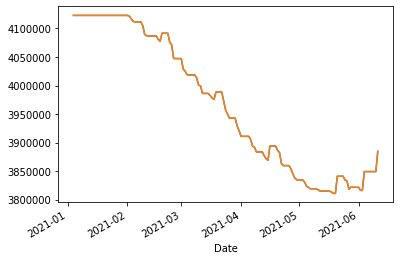

In [1165]:
# portfolio.share_flow()
# portfolio.shares()

# portfolio.cash_flow()
portfolio.cash().sum(axis=1).plot()
portfolio.cash().ffill().sum(axis=1).plot()

# portfolio.daily_returns(group_by=None)#.plot()

In [1166]:
portfolio.market_returns()#.plot()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.057143            0.000000   
2021-01-06                      -0.283784            0.000000   
2021-01-07                       0.354717            0.000000   
2021-01-08                       0.086351            0.070175   
...                                   ...                 ...   
2021-06-07                       0.000000            0.000000   
2021-06-08                       0.000000            0.000000   
2021-06-09                       0.000000            0.000000   
2021-06-10                       0.000000            0.000000   
2021-06-11                       0.000000            0.000000   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.060433            0.063158   
2021-01-06                      -0.225806           -0.229137   
2021-01-07                       0.270833            0.284404   
2021-01-08                      

In [1169]:
portfolio.active_returns()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-02-26   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210226C00135000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-05                       
oc_hx_contract_symbol AAPL210305C00136000 AAPL210305C00140000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00150000 AAPL210305C00160000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                            0.0                 0.0   
...                                   ...                 ...   
2021-06-07                            0.0                 0.0   
2021-06-08                            0.0                 0.0   
2021-06-09                            0.0                 0.0   
2021-06-10                            0.0                 0.0   
2021-06-11                            0.0                 0.0   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration              2021-03-19                       
oc_hx_contract_symbol AAPL210319C00130000 AAPL210319C00135000   
Date                                                            
2021-01-04                            0.0                 0.0   
2021-01-05                            0.0                 0.0   
2021-01-06                            0.0                 0.0   
2021-01-07                            0.0                 0.0   
2021-01-08                      

In [1170]:
portfolio[contracts].cumulative_returns()

exit_type                      expiration                      \
option_type                          CALL                       
symbol                               AAPL                       
option_expiration              2021-02-19          2021-03-05   
oc_hx_contract_symbol AAPL210219C00140000 AAPL210305C00136000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.067754           -0.061446   
2021-06-08                      -0.067754           -0.061446   
2021-06-09                      -0.067754           -0.061446   
2021-06-10                      -0.067754           -0.061446   
2021-06-11                      -0.067754           -0.061446   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210305C00140000 AAPL210305C00150000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.040182           -0.068927   
2021-06-08                      -0.040182           -0.068927   
2021-06-09                      -0.040182           -0.068927   
2021-06-10                      -0.040182           -0.068927   
2021-06-11                      -0.040182           -0.068927   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                  2021-03-19   
oc_hx_contract_symbol AAPL210305C00160000 AAPL210319C00130000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                       0.000000            0.000000   
...                                   ...                 ...   
2021-06-07                      -0.068635           -0.167916   
2021-06-08                      -0.068635           -0.167916   
2021-06-09                      -0.068635           -0.167916   
2021-06-10                      -0.068635           -0.167916   
2021-06-11                      -0.068635           -0.167916   

exit_type                                                      \
option_type                                                     
symbol                                                          
option_expiration                                               
oc_hx_contract_symbol AAPL210319C00135000 AAPL210319C00140000   
Date                                                            
2021-01-04                       0.000000            0.000000   
2021-01-05                       0.000000            0.000000   
2021-01-06                       0.000000            0.000000   
2021-01-07                       0.000000            0.000000   
2021-01-08                      

In [1171]:
portfolio[contracts].returns_stats(group_by=None)

Start                    2021-01-04 00:00:00
End                      2021-06-11 00:00:00
Duration                   111 days 00:00:00
Total Return [%]                    -6.19347
Benchmark Return [%]                -58.8332
Annual Return [%]                   -4.29438
Annual Volatility [%]                24.4598
Sharpe Ratio                        -1.91987
Calmar Ratio                       -0.667883
Max. Drawdown [%]                   -14.0603
Omega Ratio                         0.599925
Sortino Ratio                       -1.89193
Skew                                 -1.4022
Kurtosis                             29.5981
Tail Ratio                               inf
Common Sense Ratio                       inf
Value at Risk                     -0.0108122
Alpha                              -0.120047
Beta                               0.0312395
Name: <lambda>, dtype: object

In [1172]:
portfolio[contracts].value_at_risk()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.000035
                                 2021-03-05         AAPL210305C00136000     -0.005227
                                                    AAPL210305C00140000     -0.003865
                                                    AAPL210305C00150000     -0.004995
                                                    AAPL210305C00160000     -0.004640
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00060000      -0.020105
                                                    XOM210416C00065000      -0.013562
                                                    XOM210416C00070000      -0.014555
                         YCBD    2021-02-19         YCBD210219C00007500      0.000000
                         ZM      2021-05-21         ZM210521C00400

In [1173]:
portfolio.total_market_return()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.997143
                                 2021-02-26         AAPL210226C00135000     -0.998246
                                 2021-03-05         AAPL210305C00136000     -0.998750
                                                    AAPL210305C00140000     -0.998400
                                                    AAPL210305C00150000     -0.997455
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00070000      -0.913043
                         YCBD    2021-02-19         YCBD210219C00007500     -0.700000
                         ZM      2021-04-30         ZM210430C00340000       -0.999111
                                 2021-05-21         ZM210521C00360000       -0.999099
                                                    ZM210521C00400

In [922]:
portfolio.total_profit().sort_values()

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         CCL     2021-05-21         CCL210521C00030000      -12204.123
                                 2021-04-16         CCL210416C00030000       -9143.346
                                 2021-03-19         CCL210319C00030000       -7308.613
                                 2021-04-16         CCL210416C00035000       -7250.849
                                 2021-04-01         CCL210401C00030000       -6487.889
                                                                               ...    
                                 2021-03-19         CCL210319C00025000        9174.638
                                 2021-02-19         CCL210219C00021500       10291.906
                                 2021-02-26         CCL210226C00022000       13541.381
                                 2021-02-19         CCL210219C00022000       15056.237
                                                    CCL2

In [1174]:
# portfolio[contracts].get_drawdowns().plot()
# portfolio[contracts].max_drawdown(group_by=False)
# portfolio.drawdown()

cidx = 5
portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
# portfolio.get_drawdowns(group_by='symbol').plot().show()

In [1175]:
# portfolio.value().vbt.plot()

In [1176]:
portfolio.total_return(group_by=False)

exit_type   option_type  symbol  option_expiration  oc_hx_contract_symbol
expiration  CALL         AAPL    2021-02-19         AAPL210219C00140000     -0.067754
                                 2021-02-26         AAPL210226C00135000      0.000000
                                 2021-03-05         AAPL210305C00136000     -0.061446
                                                    AAPL210305C00140000     -0.040182
                                                    AAPL210305C00150000     -0.068927
                                                                               ...   
                         XOM     2021-04-16         XOM210416C00070000      -0.066001
                         YCBD    2021-02-19         YCBD210219C00007500     -0.058102
                         ZM      2021-04-30         ZM210430C00340000        0.000000
                                 2021-05-21         ZM210521C00360000        0.000000
                                                    ZM210521C00400

### Figure out how to extract trade details

In [1178]:
trade_df = portfolio.logs.records
trade_df[trade_df['order_id'] != -1].head()

,id,idx,col,group,cash_now,shares_now,val_price_now,value_now,size,size_type,...,log,new_cash,new_shares,res_size,res_price,res_fees,res_side,res_status,res_status_info,order_id
26,26,26,0,0,inf,0.0,0.78,inf,600.0,0,...,True,inf,600.0,600.0,0.78,0.468,0,0,-1,0
32,32,32,0,0,inf,600.0,0.01,inf,-600.0,0,...,True,inf,0.0,600.0,0.01,0.006,1,0,-1,1
243,243,21,2,2,inf,0.0,4.20,inf,100.0,0,...,True,inf,100.0,100.0,4.20,0.420,0,0,-1,2
264,264,42,2,2,inf,100.0,0.01,inf,-100.0,0,...,True,inf,0.0,100.0,0.01,0.001,1,0,-1,3
354,354,21,3,3,inf,0.0,2.75,inf,100.0,0,...,True,inf,100.0,100.0,2.75,0.275,0,0,-1,4


In [1179]:
symbol = 'MVIS' #'CCL210521C00030000'#'AAL210521C00025000' MVIS
cidx = [i for i,c in enumerate(contracts) if symbol in c][0]
contracts[cidx]

('expiration', 'CALL', 'MVIS', '2021-02-19', 'MVIS210219C00016000')

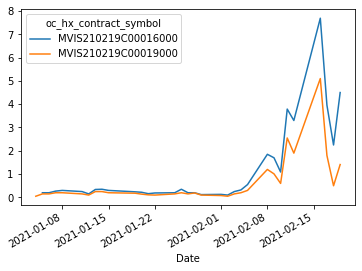

In [1180]:
df_tmp.loc[:,idx[contracts[cidx][1:4]]].plot()

In [1181]:
df_tmp.loc[:,idx[contracts[cidx][1:4]]]['AAL210219C00017000'].plot()
df_tmp.loc[:,idx[contracts[cidx][1:4]]]['AAL210219C00018000'].plot()

KeyError: 'AAL210219C00017000'

In [1182]:
portfolio[contracts[cidx][:4]].total_profit().reset_index().sort_values(by=[0],ascending=False)

,oc_hx_contract_symbol,0
0,MVIS210219C00016000,6262.770
1,MVIS210219C00019000,3020.975


In [1185]:
# portfolio.trades.records
# portfolio.orders.records
# portfolio[contracts[cidx][:4]].value()['AAL210219C00017000'].plot()
# portfolio[contracts[cidx][:4]].value()['AAL210219C00017500'].plot()
portfolio[contracts[cidx][:4]].value()['MVIS210219C00016000'].dropna()#.plot()

Date
2021-01-04     500.50
2021-01-05     500.50
2021-01-06     500.50
2021-01-07     500.50
2021-01-08     500.50
               ...   
2021-06-07    6763.27
2021-06-08    6763.27
2021-06-09    6763.27
2021-06-10    6763.27
2021-06-11    6763.27
Name: MVIS210219C00016000, Length: 111, dtype: float64

In [1186]:
# portfolio['ORCL']
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].get_drawdowns().plot().show()
# portfolio[contracts[cidx][:4]][contracts[cidx][-1]].value().plot()
portfolio[contracts[cidx][:4]].value()#.loc["2021-02-03":"2021-02-26"]

oc_hx_contract_symbol,MVIS210219C00016000,MVIS210219C00019000
Date,,
2021-01-04,500.50,500.500
2021-01-05,500.50,500.500
2021-01-06,500.50,500.500
2021-01-07,500.50,500.500
2021-01-08,500.50,500.500
...,...,...
2021-06-07,6763.27,3521.475
2021-06-08,6763.27,3521.475
2021-06-09,6763.27,3521.475


In [1187]:
df_tmp[contracts[cidx][1:4]]#.loc["2021-02-03":"2021-02-26"]

oc_hx_contract_symbol,MVIS210219C00016000,MVIS210219C00019000
Date,,
2021-01-04,NaN,0.05
2021-01-05,0.20,0.15
2021-01-06,0.20,0.15
2021-01-07,0.27,0.20
2021-01-08,0.30,0.20
...,...,...
2021-06-07,NaN,NaN
2021-06-08,NaN,NaN
2021-06-09,NaN,NaN


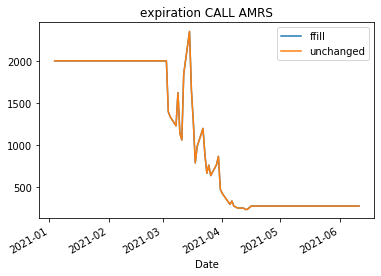

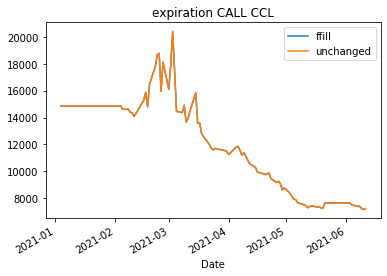

In [1188]:
# portfolio[('expiration','CALL','AMRS')].value()#['AMRS'].plot()
def plot_ffill_vs_unchanged_portfolio_value(portfolio,key='expiration',title=None):
    a = portfolio[key].value().ffill(axis=1).sum(axis=1)
    a.name = 'ffill'
    a.plot()
    b = portfolio[key].value().sum(axis=1)
    b.name = 'unchanged'
    b.plot(title=' '.join(key) if isinstance(key,tuple) else key)
    plt.legend()
    
plot_ffill_vs_unchanged_portfolio_value(portfolio,key=('expiration','CALL','AMRS'))
plt.figure()
plot_ffill_vs_unchanged_portfolio_value(portfolio,key=('expiration','CALL','CCL'))

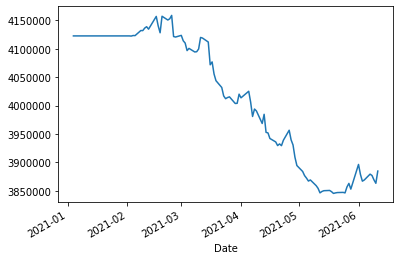

In [1190]:
portfolio['expiration'].value().sum(axis=1).plot()

In [1195]:
portfolio[('expiration','CALL','MVIS','2021-02-19','MVIS210219C00016000')].get_trades().records

,id,col,size,entry_idx,entry_price,entry_fees,exit_idx,exit_price,exit_fees,pnl,return,direction,status,position_id
0,0,0,1500.0,22,0.32,0.48,32,4.5,6.75,6262.77,13.047438,0,1,0


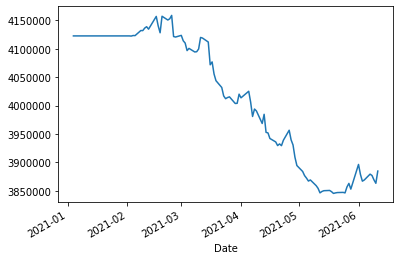

In [1201]:
# clearly need to figure this out, its not accounting for nans
portfolio.value().sum(axis=1).plot()
# portfolio.value(group_by='symbol').plot()

In [633]:
df[df['s_hx_symbol'] == 'ORCL']

contract_symbol  y_pred purch_date  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000               NaN     NaN        NaN   
           ORCL210219C00065000               NaN     NaN        NaN   
           ORCL210319C00070000               NaN     NaN        NaN   
           ORCL210319C00080000               NaN     NaN        NaN   
2021-01-05 ORCL210212C00064000               NaN     NaN        NaN   
...                                          ...     ...        ...   
2021-05-21 ORCL210521C00075000               NaN     NaN        NaN   
           ORCL210521C00077500               NaN     NaN        NaN   
           ORCL210521C00080000               NaN     NaN        NaN   
           ORCL210521C00082500               NaN     NaN        NaN   
           ORCL210521C00085000               NaN     NaN        NaN   

                                 purch_datetime  trade_price  \
oc_hx_date oc_hx_contract_symbol                               
2021-01-04 ORCL210212C00064000              NaN          NaN   
           ORCL210219C00065000              NaN          NaN   
           ORCL210319C00070000              NaN          NaN   
           ORCL210319C00080000              NaN          NaN   
2021-01-05 ORCL210212C00064000              NaN          NaN   
...                                         ...          ...   
2021-05-21 ORCL210521C00075000              NaN          NaN   
           ORCL210521C00077500              NaN          NaN   
           ORCL210521C00080000              NaN          NaN   
           ORCL210521C00082500              NaN          NaN   
           ORCL210521C00085000              NaN          NaN   

                                  open_day_after_purch  lo_day_after_purch  \
oc_hx_date oc_hx_contract_symbol                                             
2021-01-04 ORCL210212C00064000                     NaN                 NaN   
           ORCL210219C00065000                     NaN                 NaN   
           ORCL210319C00070000                     NaN                 NaN   
           ORCL210319C00080000                     NaN                 NaN   
2021-01-05 ORCL210212C00064000                     NaN                 NaN   
...                                                ...                 ...   
2021-05-21 ORCL210521C00075000                     NaN                 NaN   
           ORCL210521C00077500                     NaN                 NaN   
           ORCL210521C00080000                     NaN                 NaN   
           ORCL210521C00082500                     NaN                 NaN   
           ORCL210521C00085000                     NaN                 NaN   

                                  win  loss  close_day_of_exp  ...  oc_hx_hi  \
oc_hx_date oc_hx_contract_symbol                               ...             
2021-01-04 ORCL210212C00064000    NaN   NaN               NaN  ...      1.75   
           ORCL210219C00065000    NaN   NaN               NaN  ...      1.88   
           ORCL210319C00070000    NaN   NaN               NaN  ...      1.01   
           ORCL210319C00080000    NaN   NaN               NaN  ...      0.19   
2021-01-05 ORCL210212C00064000    NaN   NaN               NaN  ...      1.27   
...                               ...   ...               ...  ...       ...   
2021-05-21 ORCL210521C00075000    NaN   NaN               NaN  ...      4.75   
           ORCL210521C00077500    NaN   NaN               NaN  ...      2.35   
           ORCL210521C00080000    NaN   NaN               NaN  ...      0.22   
           ORCL210521C00082500    NaN   NaN               NaN  ...      0.03   
           ORCL210521C00085000    NaN   NaN               NaN  ...      0.01   

                                  oc_hx_lo  oc_hx_open  oc_hx_close  \
oc_hx_date oc_hx_contract_symbol                                      
2021-01-04 ORCL210212C00064000        1.63        1.75         1.63   
       

In [1199]:
# portfolio.plot(column='BTC-USD')
# portfolio.plot(index='BTC-USD')
portfolio.stats(group_by='symbol')

Start                            2021-01-04 00:00:00
End                              2021-06-11 00:00:00
Duration                           111 days 00:00:00
Init. Cash                                    136335
Total Profit                                -2310.79
Total Return [%]                            -1.69493
Benchmark Return [%]                         10.5696
Position Coverage [%]                        21.1635
Max. Drawdown [%]                            3.54824
Avg. Drawdown [%]                            1.99136
Max. Drawdown Duration              59 days 13:55:12
Avg. Drawdown Duration       32 days 23:18:07.200000
Num. Trades                                  5.46602
Win Rate [%]                                 10.8107
Best Trade [%]                               47.8419
Worst Trade [%]                              -35.493
Avg. Trade [%]                              -14.7573
Max. Trade Duration                 29 days 10:48:00
Avg. Trade Duration       24 days 16:37:33.445